# Analysis of whole brain mean CBF
Per reviewer recommendation, this notebook examines associations between infant affect, age, and whole-brain mean cerebral blood flow (CBF) using multiple linear regression.

### 1. Determine associations between affect variables and mean CBF

In [1]:
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink, DataGrabber
from nipype.pipeline.engine import Workflow, Node, MapNode
from nipype.interfaces.fsl import Merge, ImageMeants
from pandas import read_csv

# FSL set up- change default file output type
from nipype.interfaces.fsl import FSLCommand
FSLCommand.set_default_output_type('NIFTI_GZ')

#other study-specific variables
project_home = '/Users/catcamacho/Box/SNAP/BABIES/BABIES_asl'
template_dir = '/Users/catcamacho/Box/SNAP/BABIES/templates'
output_dir = project_home + '/proc/asl_mean_cbf'
preproc_dir = project_home + '/proc/asl_preproc'
wkflow_dir = project_home + '/workflows'
template = template_dir + '/6mo_T2w_template_2mm.nii.gz'
mask = template_dir + '/6mo_T2w_template_2mm_gm.nii.gz'

subject_info = read_csv(project_home + '/misc/subjects_info.csv',index_col=None)

In [2]:
datasink = Node(DataSink(), name='datasink')
datasink.inputs.base_directory = output_dir
datasink.inputs.container = output_dir

grabcbfdata = Node(DataGrabber(template=preproc_dir + '/cbf_volume/*/salsop_cbf_masked.nii.gz', 
                               sort_filelist=True, 
                               outfields=['cbf_list']), 
                   name='grabcbf')

merge = Node(Merge(dimension = 't'), name = 'merge')

extract_means = Node(ImageMeants(mask=mask, out_file = 'mean_cbf.txt'), name='extract_means')

In [ ]:
extractmeancbf = Workflow(name='extractmeancbf')
extractmeancbf.connect([(grabcbfdata,merge,[('cbf_list','in_files')]),
                        (merge, extract_means, [('merged_file','in_file')]),
                        (merge, datasink, [('merged_file','merged_CBF_vols')]),
                        (extract_means, datasink, [('out_file','mean_cbf_vals')])
                       ])
extractmeancbf.base_dir = wkflow_dir
#extractmeancbf.write_graph(graph2use='flat')
extractmeancbf.run('MultiProc', plugin_args={'n_procs': 2})

In [7]:
from numpy import loadtxt

cbf_means_file = output_dir + '/mean_cbf_vals/mean_cbf.txt'
cbf_means = loadtxt(cbf_means_file)

subject_info['mean_cbf'] = cbf_means
subject_info.columns

Index(['id', 'male', 'age_wks', 'mean_reg_pos', 'mean_react_dis',
       'f3_surgency', 'f3_negaff', 'f3_sensitivity', 'mean_cbf'],
      dtype='object')

In [8]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
formula = 'mean_cbf ~ age_wks + mean_reg_pos + mean_react_dis + f3_surgency + f3_negaff + f3_sensitivity + male'
mdl1 = smf.glm(formula=formula, data=subject_info).fit()

mdl1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               mean_cbf   No. Observations:                   38
Model:                            GLM   Df Residuals:                       30
Model Family:                Gaussian   Df Model:                            7
Link Function:               identity   Scale:                          41.143
Method:                          IRLS   Log-Likelihood:                -120.05
Date:                Wed, 14 Aug 2019   Deviance:                       1234.3
Time:                        14:09:37   Pearson chi2:                 1.23e+03
No. Iterations:                     3   Covariance Type:             nonrobust
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         84.5220     16.754      5.045      0.000      51.685     117.359
age_wks            0.5192      0.557      0.932      0.351      -0.572       1.611
mean_reg_pos       0.0940      0.046      2.064      0.039       0.005       0.183
mean_react_dis     0.0068      0.023      0.291      0.771      -0.039       0.052
f3_surgency        0.5132      1.468      0.350      0.727      -2.365       3.391
f3_negaff          3.2037      1.419      2.257      0.024       0.422       5.985
f3_sensitivity     0.1172      1.735      0.068      0.946      -3.283       3.517
male               2.6984      2.401      1.124      0.261      -2.007       7.404
==================================================================================
"""

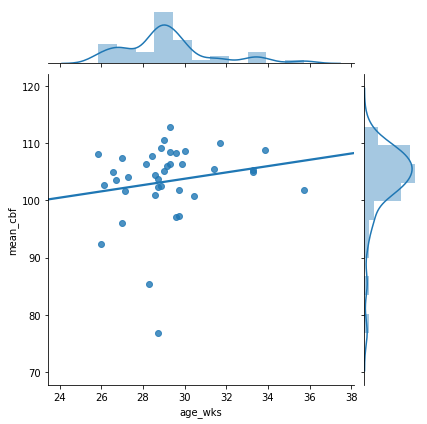

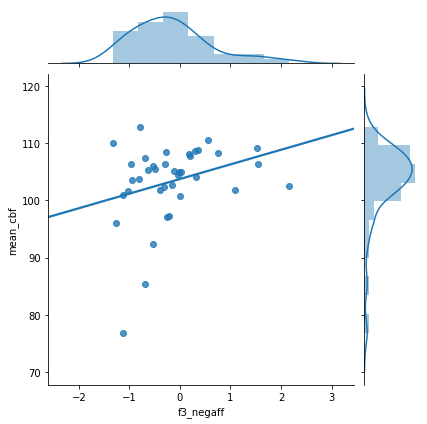

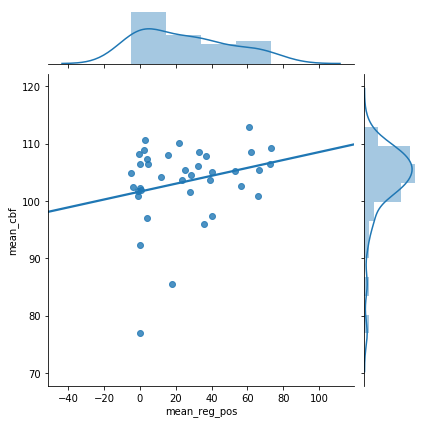

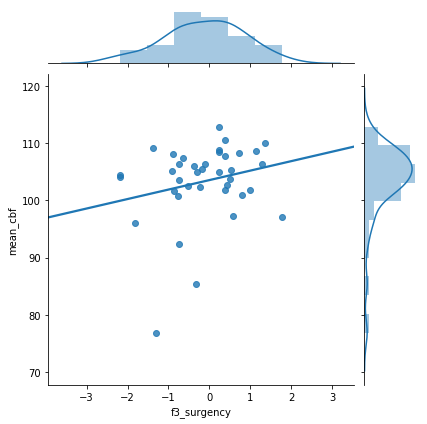

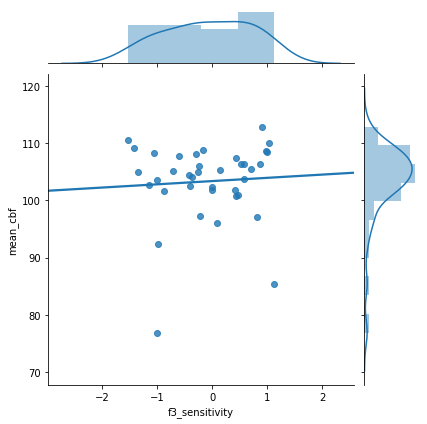

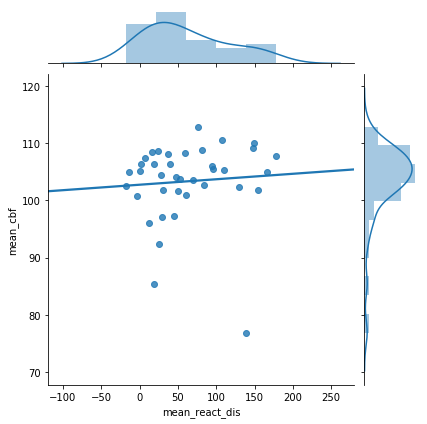

In [9]:
import seaborn as sns

sns.jointplot('age_wks','mean_cbf',data=subject_info,kind='reg',ci=None)
sns.jointplot('f3_negaff','mean_cbf',data=subject_info,kind='reg',ci=None)
sns.jointplot('mean_reg_pos','mean_cbf',data=subject_info,kind='reg',ci=None)
sns.jointplot('f3_surgency','mean_cbf',data=subject_info,kind='reg',ci=None)
sns.jointplot('f3_sensitivity','mean_cbf',data=subject_info,kind='reg',ci=None)
sns.jointplot('mean_react_dis','mean_cbf',data=subject_info,kind='reg',ci=None)

### 2. Regress out mean CBF and reexamine voxel-wise associations with residualized data

In [23]:
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink, DataGrabber
from nipype.pipeline.engine import Workflow, Node, MapNode
from nipype.interfaces.fsl.utils import Merge, Split
from nipype.interfaces.fsl.model import Randomise, Cluster, GLM
from nipype.interfaces.fsl.maths import ApplyMask

# FSL set up- change default file output type
from nipype.interfaces.fsl import FSLCommand
FSLCommand.set_default_output_type('NIFTI_GZ')

# Files for group level analysis
group_mat = project_home + '/misc/design_3factor.mat'
t_contrasts = project_home + '/misc/tcon_3factor.con'

merged_data_file = output_dir + '/merged_CBF_vols/salsop_cbf_masked_merged.nii.gz'
mean_cbf_file = output_dir + '/mean_cbf_vals/mean_cbf.txt'
subjects_list = open(project_home + '/misc/subjects_asl_final.txt').read().splitlines()

In [28]:
def get_cluster_peaks(clusters_file, stat_file):
    '''This function takes an FSL cluster output file (cluster_file; a nifti with numbered cluster 
    masks) and the statistical map from the group level analysis (stat_file; a nifti file) produces 
    a csv summary of the cluster statistics inluding the extent and peak statistic(cluster_info_file).'''
    from nibabel import load, save, Nifti1Image
    from pandas import DataFrame, Series
    from numpy import unique, unravel_index, max
    from os.path import abspath
    
    # load up clusters
    clusters_nii = load(clusters_file)
    clusters_data = clusters_nii.get_data()
    cluster_labels, cluster_sizes = unique(clusters_data, return_counts=True)
    cluster_sizes = cluster_sizes[cluster_labels>0]
    cluster_labels = cluster_labels[cluster_labels>0]
    
    # set up dataframe
    cluster_info = DataFrame(columns=['clust_num','peak','num_voxels','X','Y','Z'])
    cluster_info['clust_num'] = Series(cluster_labels,index=None)
    
    for i in range(0,len(cluster_labels)):
        # load up stat image
        stat_nii = load(stat_file)
        stat_data = stat_nii.get_data()
        stat_data[clusters_data!=cluster_labels[i]]=0
        location=unravel_index(stat_data.argmax(), stat_data.shape)
        cluster_info.iloc[i,0]=cluster_labels[i]
        cluster_info.iloc[i,1]=max(stat_data)
        cluster_info.iloc[i,2]=cluster_sizes[i]
        cluster_info.iloc[i,3]=location[0]
        cluster_info.iloc[i,4]=location[1]
        cluster_info.iloc[i,5]=location[2]
    
    out_prefix = clusters_file[:-7]
    cluster_info.to_csv(out_prefix + '_peaks.csv')
    cluster_info_file = abspath(out_prefix + '_peaks.csv')
    return(cluster_info_file)

def extract_cluster_betas(cluster_index_file, sample_betas, min_clust_size, subject_ids,num):
    '''This function extracts the subject-level data that was inputted into the group-level 
    analysis on a cluster-wise basis.'''
    from nibabel import load, save, Nifti1Image
    from pandas import DataFrame, Series
    from numpy import unique, zeros_like, invert
    from nipype.interfaces.fsl.utils import ImageMeants
    from os.path import abspath, basename
    
    sample_data = DataFrame(subject_ids, index=None, columns=['Subject'])
    
    cluster_nifti = load(cluster_index_file)
    cluster_data = cluster_nifti.get_data()
    clusters, cluster_sizes = unique(cluster_data, return_counts=True)
    cluster_sizes = cluster_sizes[clusters>0]
    clusters = clusters[clusters>0]
    clusters = clusters[cluster_sizes>min_clust_size]
    cluster_sizes = cluster_sizes[cluster_sizes>min_clust_size]
    ind_filename = basename(cluster_index_file) 
    out_prefix = ind_filename[:-7]
    
    for clust_idx in clusters:
        temp = zeros_like(cluster_data)
        temp[cluster_data==clust_idx] = 1
        temp_nii = Nifti1Image(temp,cluster_nifti.affine)
        temp_file = 'temp_clust_mask.nii.gz'
        save(temp_nii, temp_file)

        eb = ImageMeants()
        eb.inputs.in_file = sample_betas
        eb.inputs.mask = temp_file
        eb.inputs.out_file = 'betas.txt'
        eb.run()
        betas = open('betas.txt').read().splitlines()
        sample_data['clust' + str(clust_idx)] = betas
    
    sample_data.to_csv(out_prefix+'{0}_extracted_betas.csv'.format(str(num)))
    extracted_betas_csv = abspath(out_prefix+'{0}_extracted_betas.csv'.format(str(num)))

    return(extracted_betas_csv)

def text2vest_wrap(text_file):
    from subprocess import check_call
    from os.path import dirname, abspath
    
    filepath=dirname(text_file)
    vest_file_name = 'design_vest.mat'
    
    check_call(['Text2Vest',text_file,vest_file_name])
    vest_file = abspath(vest_file_name)
    
    return(vest_file)

In [25]:
vest_mcbf = Node(Function(input_names=['text_file'],
                          output_names=['vest_file'],
                          function=text2vest_wrap), name='vest_mcbf')
vest_mcbf.inputs.text_file = mean_cbf_file

regress_mcbf = Node(GLM(mask=mask, in_file=merged_data_file, 
                        out_res_name='residualized_CBF.nii.gz'), 
                    name='regress_mcbf')

model = Node(GLM(design=group_mat, mask=mask, 
                 out_p_name='pvals.nii.gz',
                 out_t_name='tstat.nii.gz', 
                 contrasts=t_contrasts), 
             name='model')

split = Node(Split(dimension='t'), name='split')

cluster = MapNode(Cluster(out_localmax_txt_file = 'cluster_stats.txt',
                          threshold=3.3256, 
                          dlh=4, 
                          pthreshold=0.01, 
                          volume=113120,
                          out_index_file='clusters.nii.gz'), 
                  name='cluster', iterfield=['in_file'])

get_peaks = MapNode(Function(input_names=['clusters_file', 'stat_file'], 
                             output_names=['cluster_info_file'], 
                             function=get_cluster_peaks), 
                    name='get_peaks', iterfield=['clusters_file', 'stat_file'])

get_betas = MapNode(Function(input_names=['cluster_index_file', 'sample_betas', 
                                          'min_clust_size', 'subject_ids'], 
                             output_names=['extracted_betas_csv'], 
                             function=extract_cluster_betas), 
                    name='get_betas', iterfield=['cluster_index_file'])
get_betas.inputs.subject_ids = subjects_list
get_betas.inputs.min_clust_size=10

In [ ]:
# Analysis workflow

grouplevel = Workflow(name='grouplevel_meancbf')

grouplevel.connect([(vest_mcbf, regress_mcbf, [('vest_file','design')]),
                    (regress_mcbf, model, [('out_res','in_file')]),
                    (model, split, [('out_t','in_file')]),
                    (split, cluster, [('out_files','in_file')]),
                    (cluster, get_peaks, [('index_file','clusters_file')]),
                    (split, get_peaks, [('out_files','stat_file')]),
                    (cluster, get_betas ,[('index_file','cluster_index_file')]),
                    (regress_mcbf, get_betas, [('out_res','sample_betas')]),
                    
                    (get_peaks, datasink, [('cluster_info_file','affect_cluster_stats')]),
                    (get_betas, datasink, [('extracted_betas_csv','affect_cluster_betas')]),
                    (model, datasink, [('out_p','pval_files'),
                                       ('out_t','tstat_files')]),
                    (cluster, datasink, [('index_file','clusters_file')])
                   ])
grouplevel.base_dir = wkflow_dir
#grouplevel.write_graph(graph2use='flat')
grouplevel.run('MultiProc', plugin_args={'n_procs': 2})